Data from Kaggle:

https://www.kaggle.com/antfarol/car-sale-advertisements

https://www.kaggle.com/satadru5/car-sale-prediction

# 1. Importing the relevant libraries

In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab
from scipy import stats

# generate classification report using predictions for categorical model
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn import (metrics,  linear_model, preprocessing)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, learning_curve, StratifiedKFold


pd.options.display.max_columns = None
pd.options.display.max_rows = None

import seaborn as sns
sns.set()

# 2. Common function

In [217]:
def Predictive_Model(num_df, cat_df, target):
    
    
    # merge num_df and dummy cat_df
    if(cat_df.shape[0] > 0):
        input_df = cat_df
        input_df = pd.concat([input_df,cat_df],axis=1)
        input_df = num_df
    
    input_df = pd.concat([input_df,num_df],axis=1)   
    
    # scaling features for numerical vars
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(input_df)
    scaled_df = scaler.transform(input_df)
    input_df = pd.DataFrame(scaled_df, columns = input_df.columns)
        
    # train test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, df[target], test_size=0.2, random_state=365)
    
    # build model
    import statsmodels.api as sm
    X = sm.add_constant(X_train)
    results = sm.OLS(y_train, X).fit()
    
    # return result
    print(results.summary())
    
    # print Rsquare of train set and test sest
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    print('Train set score: ', reg.score(X_train, y_train))
    print('Test set score: ', reg.score(X_test, y_test))

In [15]:
# Distribution plot

def analyse_continuous(df,var):
    df = df.copy()
    # df[var] = df[var].fillna(df[var].median())
    plt.figure(figsize=(20,5))
       
    # histogram
    plt.subplot(141)
    sns.distplot(df[var], bins=30)
    #sns.distplot(df[var],hist=True, kde=True,kde_kws={'shade': True, 'linewidth': 3})
    plt.title('Histogram')    
    
    # Q-Q plot
    plt.subplot(142)
    stats.probplot(df[var], dist="norm", plot=pylab)
    plt.ylabel('Quantiles')    
    
    # boxplot
    plt.subplot(143)
    sns.boxplot(x=df[var])
    plt.title('Boxplot')
          
    # skewness and kurtosis
    print('Skewness: %f' % df[var].skew())
    print('Kurtosis: %f' % df[var].kurt())
    plt.show()

# 3. Loading the raw data

In [128]:
df = pd.read_csv('CarSale.csv')
org_df = df.copy()
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


### 4.1. Dealing with missing value: Removing rows with missing values

In [129]:
print('Original shape: ', df.shape)
df = df.dropna(axis=0)
print('After removing data: ', df.shape)

df = df.reset_index(drop=True)

Original shape:  (4345, 9)
After removing data:  (4025, 9)


In [130]:
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [131]:
df['Class'] = 0
df.loc[df.Price > 15000, 'Class'] = 1
df = df.drop(['Price'],axis=1)

df[df.Class == 0].shape, df[df.Class == 1].shape

((2535, 9), (1490, 9))

In [132]:
df.head(10)

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class
0,BMW,sedan,277,2.0,Petrol,yes,1991,320,0
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,0
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,0
3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,1
4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,1
5,Mercedes-Benz,crossover,0,5.5,Petrol,yes,2016,GLS 63,1
6,BMW,sedan,438,2.0,Gas,yes,1997,320,0
7,Audi,vagon,200,2.7,Diesel,yes,2006,A6,0
8,Renault,vagon,193,1.5,Diesel,yes,2012,Megane,0
9,Volkswagen,other,212,1.8,Gas,no,1999,Golf IV,0


# 5. Experiments

In [133]:
target = 'Class'
num_vars = [var for var in df.columns if df[var].dtypes != 'O' and var != target]
num_df = df[num_vars]
cat_df = pd.DataFrame()

In [134]:
num_df.head()

,Mileage,EngineV,Year
0,277,2.0,1991
1,427,2.9,1999
2,358,5.0,2003
3,240,4.2,2007
4,120,2.0,2011


## 5.1. Exp 1 

+ Use only numerical vars

#### Independent vars

#### Variable distribution

Skewness: 0.700196
Kurtosis: 1.809798


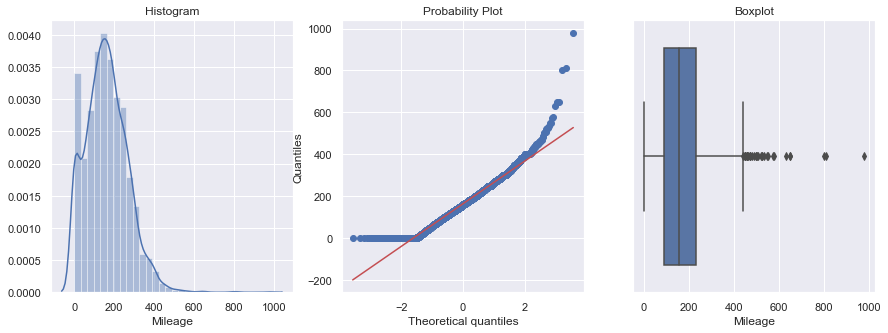

Skewness: 17.154962
Kurtosis: 316.181652


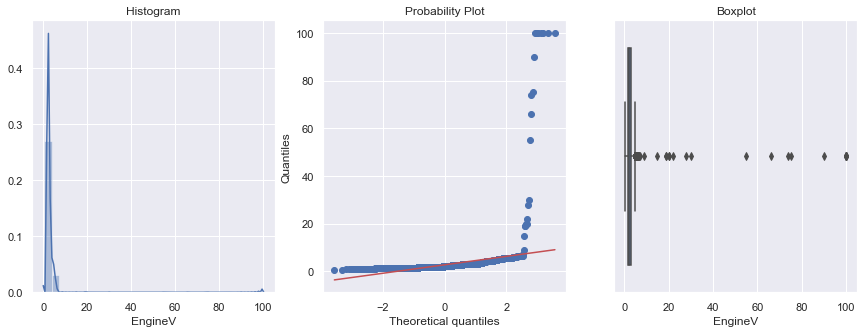

Skewness: -0.963945
Kurtosis: 0.999387


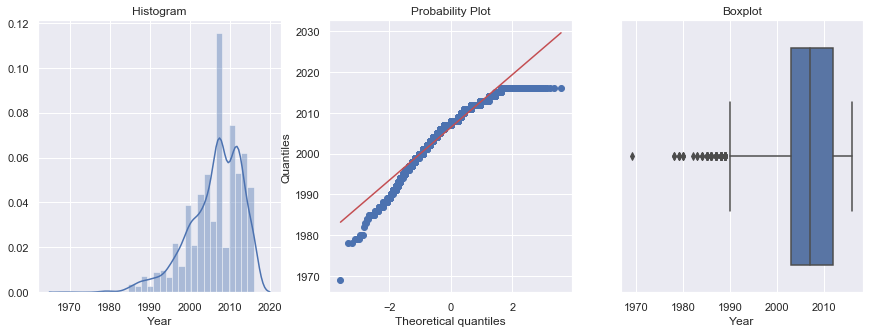

In [135]:
for var in num_vars:
    analyse_continuous(df,var)

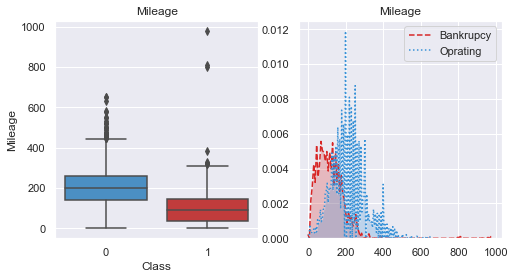

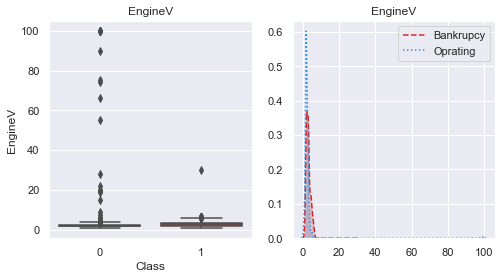

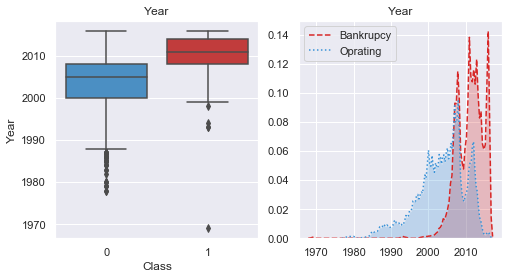

In [136]:
colors = ['#3791D7','#D72626']

for column in num_vars:    
    plt.figure(figsize=[8,4])
    plt.subplot(121)
    sns.boxplot(x='Class', y=column,data=df,palette=colors)
    plt.title(column, fontsize=12)
    plt.subplot(122)
    sns.kdeplot(df[df.Class==1][column], bw = 0.4, label = "Bankrupcy", shade=True, color="#D72626", linestyle="--")
    sns.kdeplot(df[df.Class==0][column], bw = 0.4, label = "Oprating", shade=True, color= "#3791D7", linestyle=":")
    plt.title(column, fontsize=12)
    plt.show()

In [137]:
import scipy


ttest_df = pd.DataFrame(columns = ['Feature','t-stats','p-value'])
ttest_df['Feature'] = num_vars

df0 = df[df['Class'] == 0]
df1 = df[df['Class'] == 1]

for var in num_vars:
    result = scipy.stats.ttest_ind(df0[var], df1[var])
    ttest_df.loc[ttest_df['Feature'] == var,'t-stats'] = result[0]
    ttest_df.loc[ttest_df['Feature'] == var,'p-value'] = result[1]
  
ttest_df

,Feature,t-stats,p-value
0,Mileage,36.2559,2.61373e-249
1,EngineV,-2.45385,0.0141755
2,Year,-40.4355,2.72294e-300


In [138]:
df0.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class
0,BMW,sedan,277,2.0,Petrol,yes,1991,320,0
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,0
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,0
6,BMW,sedan,438,2.0,Gas,yes,1997,320,0
7,Audi,vagon,200,2.7,Diesel,yes,2006,A6,0


In [139]:
df1.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class
3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,1
4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,1
5,Mercedes-Benz,crossover,0,5.5,Petrol,yes,2016,GLS 63,1
14,Toyota,crossover,250,4.7,Gas,yes,2001,Land Cruiser 100,1
17,Toyota,crossover,21,2.0,Petrol,yes,2013,Rav 4,1


In [140]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[num_vars], df[target], test_size = 0.25, random_state = 0, stratify = df[target])

In [141]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
model = sm.Logit(y_train, X_train_const)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.438662
         Iterations 8


In [142]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                 3018
Model:                          Logit   Df Residuals:                     3014
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Sep 2020   Pseudo R-squ.:                  0.3344
Time:                        07:57:58   Log-Likelihood:                -1323.9
converged:                       True   LL-Null:                       -1988.9
Covariance Type:            nonrobust   LLR p-value:                4.430e-288
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -473.0550     31.751    -14.899      0.000    -535.285    -410.824
Mileage       -0.0074      0.001     -8.674      0.000      -0.009      -0.006
EngineV        0.1141      0.033      3.424      0.001       0.049       0.179
Year           0.2357      0.016     14.951      0.000       0.205       0.267
==============================================================================
"""

In [143]:
prob_train_pred = result.predict(X_train_const)
y_train_pred = prob_train_pred >= 0.5
prob_test_pred = result.predict(X_test_const)
y_test_pred = result.predict(X_test_const) >= 0.5

In [144]:
def Predictive_Model(num_df, cat_df, target):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df[num_vars], df[target], test_size = 0.25, random_state = 0, stratify = df[target])
    
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    model = sm.Logit(y_train, X_train_const)
    result = model.fit()
    
    prob_train_pred = result.predict(X_train_const)
    y_train_pred = prob_train_pred >= 0.5
    prob_test_pred = result.predict(X_test_const)
    y_test_pred = result.predict(X_test_const) >= 0.5
    
    print('Model Evaluation: ')

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred))
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred))
    print(classification_report(y_test, y_test_pred))


In [172]:
Predictive_Model(num_df, cat_df, target)

ValueError: Found input variables with inconsistent numbers of samples: [3952, 5]

## 5.1. Exp 2 

+ Use only numerical vars
+ Handling outliers

In [63]:
df.shape

(4025, 9)

In [146]:
# function to find upper and lower boundaries
# for normally distributed variables

def find_normal_boundaries(df, variable):

    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

Skewness: -0.963945
Kurtosis: 0.999387


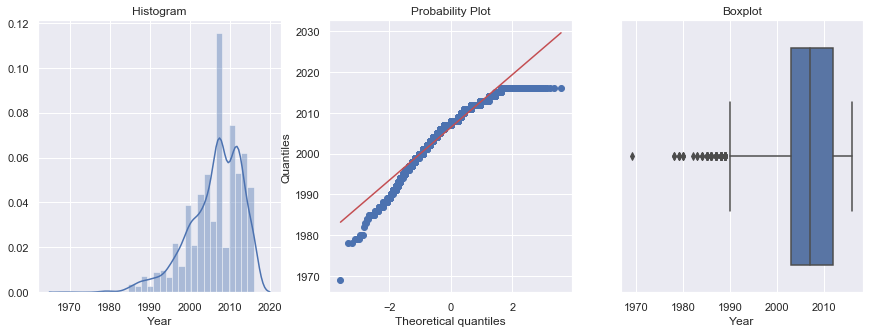

In [147]:
analyse_continuous(df,'Year')

In [148]:
# calculate boundaries for RM
upper_boundary, lower_boundary = find_normal_boundaries(df, 'Year')
upper_boundary, lower_boundary

(2026.46641322036, 1986.292841438025)

In [149]:
# inspect the number and percentage of outliers for RM

print('total number of Year: {}'.format(len(df)))

print('cars with more than upper_boundary of Year (right end outliers): {}'.format(
    len(df[df['Year'] > upper_boundary])))

print('cars with less than lower_boundary of Year (left end outliers: {}'.format(
    len(df[df['Year'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(df[df['Year'] > upper_boundary]) / len(df)))

print('% left end outliers: {}'.format(
    len(df[df['Year'] < lower_boundary]) / len(df)))

total number of Year: 4025
cars with more than upper_boundary of Year (right end outliers): 0
cars with less than lower_boundary of Year (left end outliers: 38

% right end outliers: 0.0
% left end outliers: 0.009440993788819876


In [150]:
df = df[(df.Year < upper_boundary) & (df.Year > lower_boundary)]
df.shape

(3987, 9)

Skewness: -0.762869
Kurtosis: 0.201604


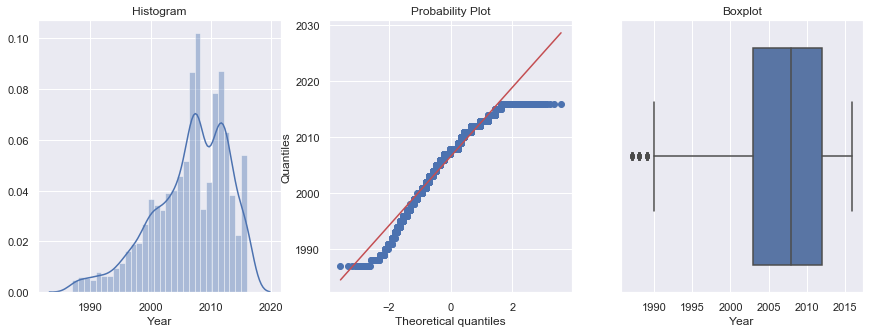

In [151]:
analyse_continuous(df,'Year')

In [152]:
# function to find upper and lower boundaries
# for skewed distributed variables


def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

Skewness: 0.706495
Kurtosis: 1.868399


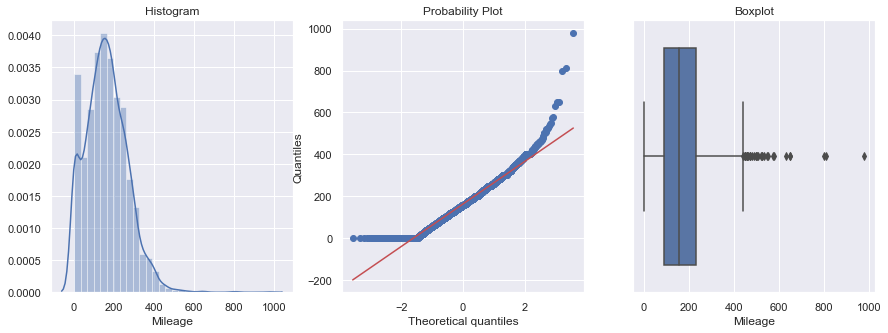

In [153]:
analyse_continuous(df,'Mileage')

In [154]:
# looking for outliers,
# using the interquantile proximity rule
# IQR * 1.5, the standard metric

# for LSTAT in the boston house dataset

upper_boundary, lower_boundary = find_skewed_boundaries(df, 'Mileage', 2)
upper_boundary, lower_boundary

(510.0, -190.0)

In [155]:
# inspect the number and percentage of outliers for RM

print('total number of Year: {}'.format(len(df)))

print('cars with more than upper_boundary of Mileage (right end outliers): {}'.format(
    len(df[df['Mileage'] > upper_boundary])))

print('cars with less than lower_boundary of Mileage (left end outliers: {}'.format(
    len(df[df['Mileage'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(df[df['Mileage'] > upper_boundary]) / len(df)))

print('% left end outliers: {}'.format(
    len(df[df['Mileage'] < lower_boundary]) / len(df)))

total number of Year: 3987
cars with more than upper_boundary of Mileage (right end outliers): 14
cars with less than lower_boundary of Mileage (left end outliers: 0

% right end outliers: 0.003511412089290193
% left end outliers: 0.0


In [156]:
df = df[(df.Mileage < upper_boundary) & (df.Mileage > lower_boundary)]
df.shape

(3973, 9)

Skewness: 0.368103
Kurtosis: -0.178503


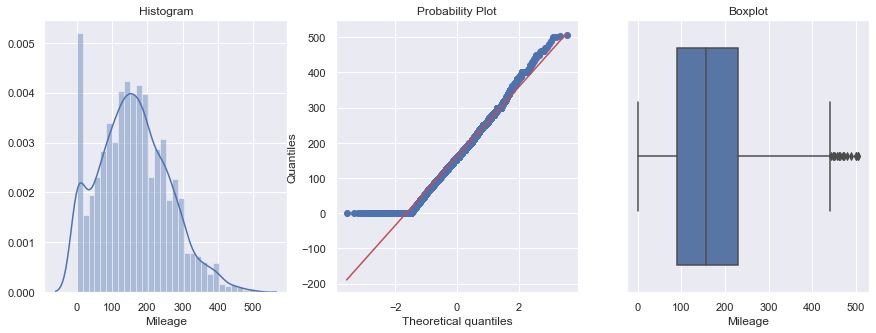

In [157]:
analyse_continuous(df,'Mileage')

Skewness: 17.049629
Kurtosis: 312.213441


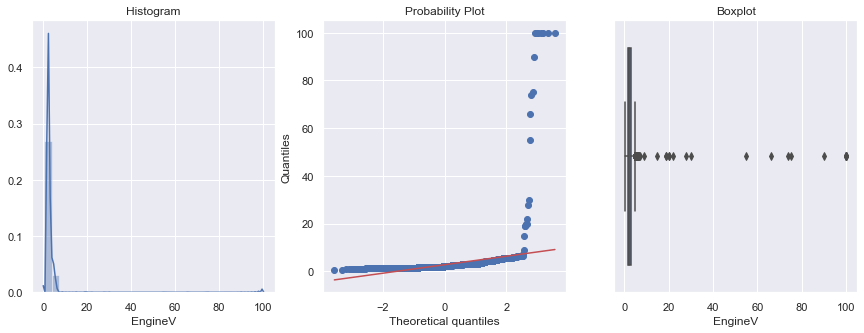

In [158]:
analyse_continuous(df,'EngineV')

In [159]:
# looking for outliers,
# using the interquantile proximity rule
# IQR * 1.5, the standard metric

# for LSTAT in the boston house dataset

upper_boundary, lower_boundary = find_skewed_boundaries(df, 'EngineV', 5)
upper_boundary, lower_boundary

(9.0, -4.2)

In [160]:
# inspect the number and percentage of outliers for RM

print('total number of Year: {}'.format(len(df)))

print('cars with more than upper_boundary of Mileage (right end outliers): {}'.format(
    len(df[df['EngineV'] > upper_boundary])))

print('cars with less than lower_boundary of Mileage (left end outliers: {}'.format(
    len(df[df['EngineV'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(df[df['EngineV'] > upper_boundary]) / len(df)))

print('% left end outliers: {}'.format(
    len(df[df['EngineV'] < lower_boundary]) / len(df)))

total number of Year: 3973
cars with more than upper_boundary of Mileage (right end outliers): 20
cars with less than lower_boundary of Mileage (left end outliers: 0

% right end outliers: 0.005033979360684621
% left end outliers: 0.0


In [161]:
df = df[(df.EngineV < upper_boundary) & (df.EngineV > lower_boundary)]
df.shape

(3952, 9)

Skewness: 1.492797
Kurtosis: 2.256621


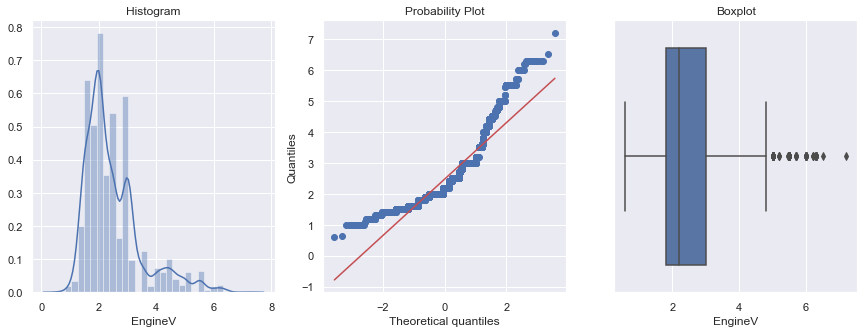

In [162]:
analyse_continuous(df,'EngineV')

In [220]:
df = df.reset_index(drop = True)
target = 'Class'
num_df = df[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

UnboundLocalError: local variable 'input_df' referenced before assignment

In [164]:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df[num_vars], df[target], test_size = 0.25, random_state = 0, stratify = df[target])
    
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    model = sm.Logit(y_train, X_train_const)
    result = model.fit()
    
    prob_train_pred = result.predict(X_train_const)
    y_train_pred = prob_train_pred >= 0.5
    prob_test_pred = result.predict(X_test_const)
    y_test_pred = result.predict(X_test_const) >= 0.5
    
    print('Model Evaluation: ')

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred))
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred))
    print(classification_report(y_test, y_test_pred))


Optimization terminated successfully.
         Current function value: 0.278342
         Iterations 9
Model Evaluation: 
-----------------------------------------------------------
Train set
Accuracy:  0.8778677462887989
ROC AUC Score:  0.9486661167451115
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1850
           1       0.85      0.81      0.83      1114

    accuracy                           0.88      2964
   macro avg       0.87      0.87      0.87      2964
weighted avg       0.88      0.88      0.88      2964

-----------------------------------------------------------
Test set
Accuracy:  0.861336032388664
ROC AUC Score:  0.94324114159899
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       617
           1       0.83      0.79      0.81       371

    accuracy                           0.86       988
   macro avg       0.85      0.85      0.85       988
weighted avg  

In [232]:
dummy_df = pd.get_dummies(df[['Brand','Body','Engine Type']], drop_first=True)
cat_df = dummy_df.copy()
#cat_df = pd.DataFrame()
print(cat_df.shape)
cat_df.head()

(3952, 14)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [233]:
input_df = pd.concat([num_df, cat_df],axis=1)
input_df.head()

,Mileage,EngineV,Year,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol
0,277,2.0,1991,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,427,2.9,1999,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,358,5.0,2003,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,240,4.2,2007,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,120,2.0,2011,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [234]:
    input_df = pd.concat([num_df, cat_df],axis=1)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, df[target], test_size = 0.25, random_state = 0, stratify = df[target])
    
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    model = sm.Logit(y_train, X_train_const)
    result = model.fit()
    
    prob_train_pred = result.predict(X_train_const)
    y_train_pred = prob_train_pred >= 0.5
    prob_test_pred = result.predict(X_test_const)
    y_test_pred = result.predict(X_test_const) >= 0.5
    
    print('Model Evaluation: ')

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred))
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred))
    print(classification_report(y_test, y_test_pred))

Optimization terminated successfully.
         Current function value: 0.198587
         Iterations 10
Model Evaluation: 
-----------------------------------------------------------
Train set
Accuracy:  0.9159919028340081
ROC AUC Score:  0.9745577175020622
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1850
           1       0.90      0.88      0.89      1114

    accuracy                           0.92      2964
   macro avg       0.91      0.91      0.91      2964
weighted avg       0.92      0.92      0.92      2964

-----------------------------------------------------------
Test set
Accuracy:  0.9129554655870445
ROC AUC Score:  0.9728754472340294
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       617
           1       0.88      0.89      0.89       371

    accuracy                           0.91       988
   macro avg       0.91      0.91      0.91       988
weighted a

In [235]:
input_df.shape

(3952, 17)

In [236]:
dummy_df = pd.get_dummies(df[['Brand','Body','Engine Type','Model']], drop_first=True)
cat_df = dummy_df.copy()
#cat_df = pd.DataFrame()
print(cat_df.shape)
cat_df.head()

(3952, 314)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Model_100,Model_11,Model_116,Model_118,Model_120,Model_19,Model_190,Model_200,Model_210,Model_220,Model_230,Model_25,Model_250,Model_300,Model_316,Model_318,Model_320,Model_323,Model_324,Model_325,Model_328,Model_330,Model_335,Model_4 Series Gran Coupe,Model_428,Model_4Runner,Model_5,Model_5 Series,Model_5 Series GT,Model_520,Model_523,Model_524,Model_525,Model_528,Model_530,Model_535,Model_540,Model_545,Model_550,Model_6 Series Gran Coupe,Model_630,Model_640,Model_645,Model_650,Model_730,Model_735,Model_740,Model_745,Model_750,Model_760,Model_80,Model_9,Model_90,Model_A 140,Model_A 150,Model_A 170,Model_A 180,Model_A1,Model_A3,Model_A4,Model_A4 Allroad,Model_A5,Model_A6,Model_A6 Allroad,Model_A7,Model_A8,Model_ASX,Model_Amarok,Model_Auris,Model_Avalon,Model_Avensis,Model_Aygo,Model_B 170,Model_B 180,Model_B 200,Model_Beetle,Model_Bora,Model_C-Class,Model_CL 180,Model_CL 500,Model_CL 55 AMG,Model_CL 550,Model_CL 63 AMG,Model_CLA 200,Model_CLA 220,Model_CLA-Class,Model_CLC 180,Model_CLC 200,Model_CLK 200,Model_CLK 220,Model_CLK 230,Model_CLK 240,Model_CLK 280,Model_CLK 320,Model_CLK 430,Model_CLS 350,Model_CLS 400,Model_CLS 500,Model_CLS 63 AMG,Model_Caddy,Model_Camry,Model_Captur,Model_Caravelle,Model_Carina,Model_Carisma,Model_Celica,Model_Clio,Model_Colt,Model_Corolla,Model_Corolla Verso,Model_Cross Touran,Model_Dokker,Model_Duster,Model_E-Class,Model_Eclipse,Model_Eos,Model_Espace,Model_FJ Cruiser,Model_Fluence,Model_Fortuner,Model_G 320,Model_G 350,Model_G 500,Model_G 55 AMG,Model_G 63 AMG,Model_GL 320,Model_GL 350,Model_GL 420,Model_GL 450,Model_GL 500,Model_GL 550,Model_GLC-Class,Model_GLE-Class,Model_GLK 220,Model_GLK 300,Model_GLS 350,Model_GLS 400,Model_GLS 500,Model_GLS 63,Model_Galant,Model_Golf GTI,Model_Golf II,Model_Golf III,Model_Golf IV,Model_Golf Plus,Model_Golf V,Model_Golf VI,Model_Golf VII,Model_Golf Variant,Model_Grand Scenic,Model_Grandis,Model_Hiace,Model_Highlander,Model_Hilux,Model_I3,Model_IQ,Model_Jetta,Model_Kangoo,Model_Koleos,Model_L 200,Model_LT,Model_Laguna,Model_Lancer,Model_Lancer Evolution,Model_Lancer X,Model_Lancer X Sportback,Model_Land Cruiser 100,Model_Land Cruiser 105,Model_Land Cruiser 200,Model_Land Cruiser 76,Model_Land Cruiser 80,Model_Land Cruiser Prado,Model_Latitude,Model_Logan,Model_Lupo,Model_M5,Model_M6,Model_MB,Model_ML 250,Model_ML 270,Model_ML 280,Model_ML 320,Model_ML 350,Model_ML 400,Model_ML 430,Model_ML 500,Model_ML 550,Model_ML 63 AMG,Model_Mark II,Model_Master,Model_Matrix,Model_Megane,Model_Modus,Model_Multivan,Model_New Beetle,Model_Outlander,Model_Outlander XL,Model_Pajero,Model_Pajero Pinin,Model_Pajero Sport,Model_Pajero Wagon,Model_Passat B2,Model_Passat B3,Model_Passat B4,Model_Passat B5,Model_Passat B6,Model_Passat B7,Model_Passat B8,Model_Passat CC,Model_Phaeton,Model_Pointer,Model_Polo,Model_Previa,Model_Prius,Model_Q3,Model_Q5,Model_Q7,Model_R 320,Model_R8,Model_Rav 4,Model_S 140,Model_S 250,Model_S 300,Model_S 320,Model_S 350,Model_S 400,Model_S 420,Model_S 430,Model_S 500,Model_S 550,Model_S 600,Model_S 63 AMG,Model_S 65 AMG,Model_S-Guard,Model_S4,Model_S5,Model_S8,Model_SL 500 (550),Model_SL 55 AMG,Model_SLK 200,Model_SLK 350,Model_Sandero,Model_Sandero StepWay,Model_Scenic,Model_Scion,Model_Scirocco,Model_Sequoia,Model_Sharan,Model_Sienna,Model_Smart,Model_Space Star,Model_Space Wagon,Model_Sprinter,Model_Sprinter 208,Model_Sprinter 210,Model_Sprinter 211,Model_Sprinter 212,Model_Sprinter 213,Model_Sprinter 311,Model_Sprinter 312,Model_Sprinter 313,Model_Sprinter 315,Model_Sprinter 316,Model_Sprinter 318,Model_Sprinter 319,Model_Sprinter 324,Model_Symbol,Model_Syncro,Model_T3 (Transporter),Model_T4 (Transporter),Model_T4 (Transporter),Model_T5 (Transporter),Model_T5 (Transporter),Model_T6 (Transporter),Model_T6 (Transporter),Model_TT,Model_Tacoma,Model_Tiguan

In [237]:
    input_df = pd.concat([num_df, cat_df],axis=1)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, df[target], test_size = 0.25, random_state = 0, stratify = df[target])
    
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    model = sm.Logit(y_train, X_train_const)
    result = model.fit()
    
    prob_train_pred = result.predict(X_train_const)
    y_train_pred = prob_train_pred >= 0.5
    prob_test_pred = result.predict(X_test_const)
    y_test_pred = result.predict(X_test_const) >= 0.5
    
    print('Model Evaluation: ')

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred))
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred))
    print(classification_report(y_test, y_test_pred))

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\statsmodels\discrete\discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [238]:
import re 

def LetterPart_Extraction(init_string):
    # letter_part = " ".join(re.findall("[a-zA-Z]+", ini_string)) 
    letter_part = ''.join(filter(lambda chr: chr.isalpha(), init_string))
    return letter_part

def NumberPart_Extraction(init_string):
    # number_part = [int(s) for s in init_string.split() if s.isdigit()]
    number_part = ''.join(filter(lambda i: i.isdigit(), init_string))
    # number_part = list(map(int, re.findall(r'\d+', init_string))) 
    return number_part

df['Model_categorical'] = df.Model.apply(lambda x:LetterPart_Extraction(x))
df['Model_numerical'] = df.Model.apply(lambda x:NumberPart_Extraction(x))
df.head(5)

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class,Model_categorical,Model_numerical
0,BMW,sedan,277,2.0,Petrol,yes,1991,320,0,,320
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,0,Sprinter,212
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,0,S,500
3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,1,Q,7
4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,1,Rav,4


In [304]:
# I will replace all the labels that appear in less than 5%
# of the houses by the label 'rare'


def group_rare_labels(df, var):

    total_houses = len(df)

    # first I calculate the % of houses for each category
    temp_df = pd.Series(df[var].value_counts() / total_houses)

    # now I create a dictionary to replace the rare labels with the
    # string 'rare' if they are present in less than 5% of houses

    grouping_dict = {
        k: ('rare' if k not in temp_df[temp_df >= 0.025].index else k)
        for k in temp_df.index
    }

    # now I replace the rare categories
    tmp = df[var].map(grouping_dict)

    return tmp

In [305]:
# group rare labels in Neighborhood

df['Model_categorical_grouped'] = group_rare_labels(df, 'Model_categorical')

df[['Model_categorical', 'Model_categorical_grouped']].head(10)

,Model_categorical,Model_categorical_grouped
0,,
1,Sprinter,rare
2,S,S
3,Q,rare
4,Rav,rare
5,GLS,rare
6,,
7,A,A
8,Megane,rare
9,GolfIV,rare


In [306]:
df.Model_categorical_grouped.unique()

array(['', 'rare', 'S', 'A', 'PassatB', 'Vito', 'X', 'Caddy', 'Camry',
       'Kangoo', 'EClass', 'TTransporter'], dtype=object)

In [307]:
df.Model_categorical_grouped = df.Model_categorical_grouped.replace('','Missing')

In [308]:
dummy_df = pd.get_dummies(df[['Brand','Body','Engine Type','Model_categorical_grouped']], drop_first=True)
cat_df = dummy_df.copy()
#cat_df = pd.DataFrame()
print(cat_df.shape)
cat_df.head()

(3952, 25)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Model_categorical_grouped_Caddy,Model_categorical_grouped_Camry,Model_categorical_grouped_EClass,Model_categorical_grouped_Kangoo,Model_categorical_grouped_Missing,Model_categorical_grouped_PassatB,Model_categorical_grouped_S,Model_categorical_grouped_TTransporter,Model_categorical_grouped_Vito,Model_categorical_grouped_X,Model_categorical_grouped_rare
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [309]:
    input_df = pd.concat([num_df, cat_df],axis=1)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, df[target], test_size = 0.25, random_state = 0, stratify = df[target])
    
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    model = sm.Logit(y_train, X_train_const)
    result = model.fit()
    
    prob_train_pred = result.predict(X_train_const)
    y_train_pred = prob_train_pred >= 0.5
    prob_test_pred = result.predict(X_test_const)
    y_test_pred = result.predict(X_test_const) >= 0.5
    
    print('Model Evaluation: ')

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred))
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred))
    print(classification_report(y_test, y_test_pred))

         Current function value: 0.174705
         Iterations: 35
Model Evaluation: 
-----------------------------------------------------------
Train set
Accuracy:  0.9278002699055331
ROC AUC Score:  0.9803639186763065
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1850
           1       0.91      0.89      0.90      1114

    accuracy                           0.93      2964
   macro avg       0.92      0.92      0.92      2964
weighted avg       0.93      0.93      0.93      2964

-----------------------------------------------------------
Test set
Accuracy:  0.9240890688259109
ROC AUC Score:  0.9759247205196871
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       617
           1       0.90      0.90      0.90       371

    accuracy                           0.92       988
   macro avg       0.92      0.92      0.92       988
weighted avg       0.92      0.92      0.92    

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [310]:
dummy_df = pd.get_dummies(df[['Brand','Body','Engine Type','Model_categorical_grouped','Registration']], drop_first=True)
cat_df = dummy_df.copy()
#cat_df = pd.DataFrame()
print(cat_df.shape)
cat_df.head()

(3952, 26)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Model_categorical_grouped_Caddy,Model_categorical_grouped_Camry,Model_categorical_grouped_EClass,Model_categorical_grouped_Kangoo,Model_categorical_grouped_Missing,Model_categorical_grouped_PassatB,Model_categorical_grouped_S,Model_categorical_grouped_TTransporter,Model_categorical_grouped_Vito,Model_categorical_grouped_X,Model_categorical_grouped_rare,Registration_yes
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [311]:
    input_df = pd.concat([num_df, cat_df],axis=1)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, df[target], test_size = 0.25, random_state = 0, stratify = df[target])
    
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    model = sm.Logit(y_train, X_train_const)
    result = model.fit()
    
    prob_train_pred = result.predict(X_train_const)
    y_train_pred = prob_train_pred >= 0.5
    prob_test_pred = result.predict(X_test_const)
    y_test_pred = result.predict(X_test_const) >= 0.5
    
    print('Model Evaluation: ')

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred))
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred))
    print(classification_report(y_test, y_test_pred))

         Current function value: 0.162172
         Iterations: 35
Model Evaluation: 
-----------------------------------------------------------
Train set
Accuracy:  0.9328609986504723
ROC AUC Score:  0.9828817506914456
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1850
           1       0.92      0.90      0.91      1114

    accuracy                           0.93      2964
   macro avg       0.93      0.93      0.93      2964
weighted avg       0.93      0.93      0.93      2964

-----------------------------------------------------------
Test set
Accuracy:  0.9261133603238867
ROC AUC Score:  0.9781876482588999
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       617
           1       0.90      0.90      0.90       371

    accuracy                           0.93       988
   macro avg       0.92      0.92      0.92       988
weighted avg       0.93      0.93      0.93    

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


## Exp3

+ Use only numerical vars
+ Remove outliers
+ transform Price to have linear relationship

## Exp4

+ Use only numerical vars
+ Remove outliers
+ transform Price to have linear relationship
+ transform independent vars to have Normal distribution